In [0]:
# Load FILE
from google.colab import files
uploaded = files.upload()


Saving Data_hb2_61_83.csv to Data_hb2_61_83.csv
Saving Data_hb2_84.csv to Data_hb2_84.csv


In [0]:
# Seed value
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value
                   
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('Data_hb2_61_83.csv', header=0, index_col=0)
data_org = dataset.iloc[:, :].values
# Case HB2_1d
input_dim = data_org.shape[1]                
output_dim = 1
seq_length = 10                              
num_units = 20                                  
num_cells = 1                                 
learning_rate = 0.0001                         
keep_prob = 0.7                               
size_train = 6574                              # Valid 1979-1983  (Good)               
data_train = data_org[0 : size_train]
data_valid = data_org[size_train : len(data_org)]
scaler = MinMaxScaler()
train_data = scaler.fit_transform(data_train)
valid_data = scaler.transform(data_valid)
n = 1                                          
def split_data(x_data):
    dataX = []
    dataY = []
    y_data = x_data[:, [-1]]
    for i in range(seq_length, len(y_data) - (n-1)):
        _x = x_data[i - seq_length : i]
        _y = y_data[i + (n-1)] 
        dataX.append(_x)
        dataY.append(_y)
    return dataX, dataY
trainX, trainY = split_data(train_data)
validX, validY = split_data(valid_data)

Length of raw data is:  (8400, 5)
Length of input data is:  6564
Data shape for training is trainX.shape; trainY.shape:  (6564, 10, 5) (6564, 1)
Data shape for validation is validX.shape; validY.shape:  (1816, 10, 5) (1816, 1)


In [0]:
X = tf.placeholder(tf.float32, [None, seq_length, input_dim])
Y = tf.placeholder(tf.float32, [None, 1])
cell = tf.contrib.rnn.LSTMCell(num_units)
is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
keep_prob = tf.cond(is_training, lambda:tf.constant(keep_prob), lambda:tf.constant(1.0))
cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob = keep_prob)
multi_cell = tf.contrib.rnn.MultiRNNCell([cell] * num_cells, state_is_tuple=True)
multi_cell = tf.contrib.rnn.DropoutWrapper(multi_cell, output_keep_prob = keep_prob)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn = None)

loss = tf.reduce_mean(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
X: Tensor("Placeholder:0", shape=(?, 10, 5), dtype=float32)
Y: Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
OK


In [0]:
# Create a Saver
saver = tf.train.Saver()
save_dir = 'hb2_1d.20/'
model_name = 'hb2_1d.20'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, model_name)       
train_loss_summary = []               
valid_loss_summary = []               
train_pred = '' 
valid_pred = ''                      

# Start the session and initialized variables. Variables needs to be initialized
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)
best_valid_loss = 1                
best_train_loss = 1
last_improvement = 0                  
require_improvement = 2000            
total_iterations = 0                 
print('OK')

OK


In [0]:
def optimize(num_epochs):
    global total_iterations           # Ensure we update the global variables rather than local copies.
    global best_train_loss
    global best_valid_loss
    global last_improvement
    start_time = time.time()  
    for epoch in range(num_epochs):
        total_iterations += 1
        sess.run(optimizer, feed_dict={X: trainX, Y: trainY})     
        train_pred = sess.run(Y_pred, feed_dict={X: trainX})
        train_loss = sess.run(rmse, feed_dict={targets: trainY, predictions: train_pred})
        train_loss_summary.append(train_loss)           
        valid_pred = sess.run(Y_pred, feed_dict={X: validX})
        valid_loss = sess.run(rmse, feed_dict={targets: validY, predictions: valid_pred})
        valid_loss_summary.append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss                    
            last_improvement = total_iterations   
            saver.save(sess, save_path, global_step = total_iterations)                              
            improved_str = '*'              
        else:
            improved_str = ''                         
        if (total_iterations % 100 == 0) or (epoch == (num_epochs - 1)):
            msg = "Iter: {0:>6}, Training Loss: {1:>6.8}, Validation Loss: {2:>6.8} {3}"
            print(msg.format(epoch + 1, train_loss, valid_loss, improved_str))
        if total_iterations - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")
            break                                   
    end_time = time.time()                          
    time_dif = end_time - start_time                
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    print('Total training time is ', time_dif, '(s)')
    print('Training time per epoch is ', time_dif/num_epochs, '(s)') 
print('OK')

OK


In [0]:
# RUN MODEL
num_epochs = 100000
optimize(num_epochs)

Instructions for updating:
Use standard file APIs to delete files with this prefix.
Iter:    100, Training Loss: 0.052695613, Validation Loss: 0.04438417 *
Iter:    200, Training Loss: 0.041427605, Validation Loss: 0.033743702 *
Iter:    300, Training Loss: 0.038656667, Validation Loss: 0.031078627 *
Iter:    400, Training Loss: 0.037331171, Validation Loss: 0.030012598 *
Iter:    500, Training Loss: 0.036083676, Validation Loss: 0.029025216 *
Iter:    600, Training Loss: 0.034872558, Validation Loss: 0.028068267 *
Iter:    700, Training Loss: 0.033690389, Validation Loss: 0.027137095 *
Iter:    800, Training Loss: 0.032533038, Validation Loss: 0.02622913 *
Iter:    900, Training Loss: 0.0313989, Validation Loss: 0.025343357 *
Iter:   1000, Training Loss: 0.030288877, Validation Loss: 0.024480373 *
Iter:   1100, Training Loss: 0.029206347, Validation Loss: 0.023642506 *
Iter:   1200, Training Loss: 0.028156945, Validation Loss: 0.022833709 *
Iter:   1300, Training Loss: 0.027147811, Va

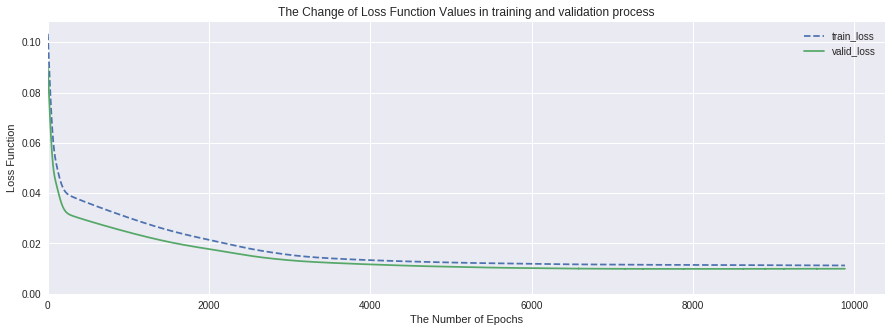

The last epoch:  7887


In [0]:
#Plot the training and validation process
%matplotlib inline
plt.figure(num = 1, figsize = (15,5))
plt.plot(train_loss_summary, '--', label = 'train_loss')
plt.plot(valid_loss_summary, label = 'valid_loss')
plt.title('The Change of Loss Function Values in training and validation process')
plt.legend()
plt.xlim(0)
plt.ylim(0)
plt.xlabel('The Number of Epochs')
plt.ylabel('Loss Function')
plt.show()
np.savetxt('hb2_1d.20/loss_train.csv', train_loss_summary, delimiter='\n')
np.savetxt('hb2_1d.20/loss_valid.csv', valid_loss_summary, delimiter='\n')
print('The last epoch: ', total_iterations - require_improvement - 1)

In [0]:
saver = tf.train.Saver()
save_dir = 'hb2_1d.20/'
model_name = 'hb2_1d.20-7887'
save_path = os.path.join(save_dir, model_name)  
saver.restore(sess, save_path)   
print('OK')

INFO:tensorflow:Restoring parameters from hb2_1d.20/hb2_1d.20-7887
OK


(1816, 1)
(1826, 5)
[416.]
[411.44864559]
MAE for Validation dataset: 69.578 (m3/s)
RMSE for Validation dataset: 165.001 (m3/s)
NSE for Validation dataset: 98.97%


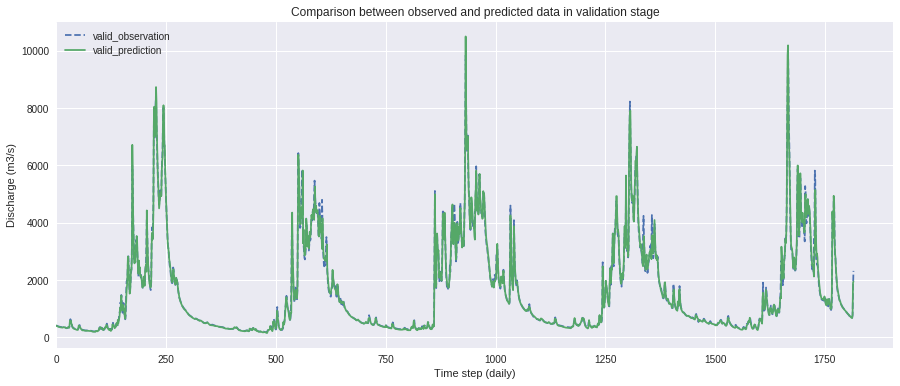

OK


In [0]:
valid_pred = sess.run(Y_pred, feed_dict={X: validX})
data_recover = np.concatenate((valid_data[seq_length+(n-1) :, 0: (input_dim - 1)], valid_pred), axis=1)
data_invert = scaler.inverse_transform(data_recover)
org_valid_pred = data_invert[:, [-1]]                           
org_validY = data_valid[seq_length+(n-1) :, [-1]]

# Calculating the error on test data
NSE_valid = 100*r2_score(org_validY, org_valid_pred)
MAE_valid = mean_absolute_error(org_validY, org_valid_pred)
RMSE_valid = np.sqrt(mean_squared_error(org_validY, org_valid_pred))
print("MAE for Validation dataset: {}".format(np.around(MAE_valid, decimals = 3)), '(m3/s)')
print('RMSE for Validation dataset: %.3f' % RMSE_valid, '(m3/s)')    # 2 ways to show
print("NSE for Validation dataset: {}%".format(np.around(NSE_valid, decimals = 2)))

# Plot Validation data
%matplotlib inline
plt.figure(num = 2, figsize = (15,6))
plt.plot(org_validY, '--', label = 'valid_observation')
plt.plot(org_valid_pred, label = 'valid_prediction')
plt.title('Comparison between observed and predicted data in validation stage')
plt.legend()
plt.xlim(0)
plt.ylim()
plt.xlabel('Time step (daily)')
plt.ylabel('Discharge (m3/s)')
plt.show()
np.savetxt('hb2_1d.20/KQ_1 Actual.csv', org_validY, delimiter='\n')
np.savetxt('hb2_1d.20/KQ_1.20 Predict.csv', org_valid_pred, delimiter='\n')
print('OK')

Shape of prediction data:  (356, 10, 5)
(356, 1) (366, 5)
- Observed peak-flood: Q_orig 10000.00 m3/s
- Predicted peak-flood: Q_pred 9563.62 m3/s
MAE for Prediction dataset: 81.122 (m3/s)
RMSE for Prediction dataset: 150.047 (m3/s)
NSE for Prediction dataset: 99.12%


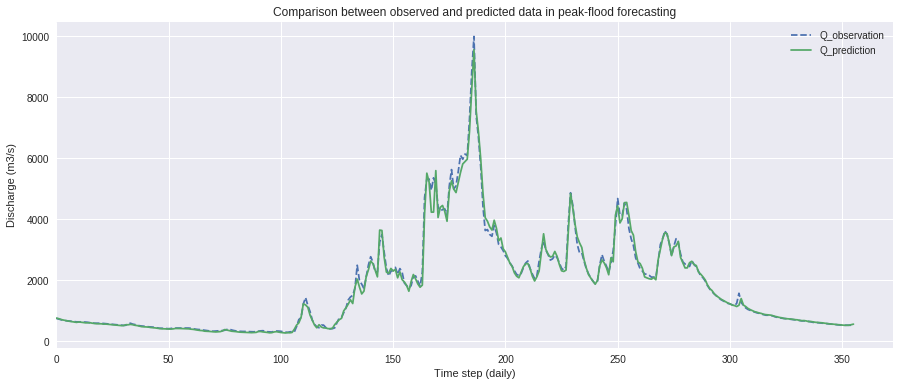

FINISH


In [0]:
# *** CREATE a data file FOR FORECASTING ***
dataset_pred = pd.read_csv('Data_hb2_84.csv', header=0, index_col=0)
data_pred = dataset_pred.iloc[:, :].values                  
pred_data = scaler.transform(data_pred)
predX, predY = split_data(pred_data)

# Forecast 
pred_Z = sess.run(Y_pred, feed_dict = {X: predX})
pred_recover = np.concatenate((pred_data[seq_length+(n-1) :, 0: (input_dim - 1)], pred_Z), axis=1)
pred_invert = scaler.inverse_transform(pred_recover)
Q_pred = pred_invert[:, [-1]]  
Q_orig = data_pred[seq_length+(n-1) :, [-1]]

# Calculating the error on test data
MAE_pred = mean_absolute_error(Q_orig, Q_pred)
RMSE_pred = np.sqrt(mean_squared_error(Q_orig, Q_pred))
NSE_pred = 100*r2_score(Q_orig, Q_pred)
print("MAE for Prediction dataset: {}".format(np.around(MAE_pred, decimals = 3)), '(m3/s)')
print('RMSE for Prediction dataset: %.3f' % RMSE_pred, '(m3/s)')    # 2 ways to show
print("NSE for Prediction dataset: {}%".format(np.around(NSE_pred, decimals = 2)))

# Plot Prediction dataset
%matplotlib inline
plt.figure(num = 3, figsize = (15,6))
plt.plot(Q_orig, '--', label = 'Q_observation')
plt.plot(Q_pred, label = 'Q_prediction')
plt.title('Comparison between observed and predicted data in peak-flood forecasting')
plt.legend()
plt.xlim(0)
plt.ylim()
plt.xlabel('Time step (daily)')
plt.ylabel('Discharge (m3/s)')
plt.show()
np.savetxt('hb2_1d.20/KQ_pred_1 Actual.csv', Q_orig, delimiter='\n')
np.savetxt('hb2_1d.20/KQ_pred_1.20 Predict.csv', Q_pred, delimiter='\n')
print('FINISH')